# FSB: Filtered-Squared Bispectra

In [1]:
from fsb import *
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

## Data

In [2]:
# let's make some non-gaussian maps 

nside = 256
npix = hp.nside2npix(nside)

# cot map
colat, lon = hp.pix2ang(nside, np.arange(npix), lonlat=False)
cotmap = np.cos(colat) / np.sin(colat) # lat or colat?

def generate_map(cl):

    delta = hp.synfast(cl, nside)
    dlm = hp.map2alm(delta) 

    f = -1/(ells*(ells+1))
    f[0] = 2*f[1]
    philm = hp.almxfl(dlm, f)
    phi = hp.alm2map(philm, nside)

    # now let's get the hessian components
    phiagain, dtphi, dvphi_sin = hp.alm2map_der1(philm, nside, lmax=3*nside-1) 

    dtphi_lm = hp.map2alm(dtphi) 
    dtphiagain, d2tphi, dvdtphi_sin = hp.alm2map_der1(dtphi_lm, nside, lmax=3*nside-1) 

    dvphi_sin_lm = hp.map2alm(dvphi_sin) 
    dvphi_sinagain, dtdvphi_sin, d2vphi_sin2 = hp.alm2map_der1(dvphi_sin_lm, nside, lmax=3*nside-1) 

    htt = d2tphi
    htv = dtdvphi_sin
    hvv = d2vphi_sin2 + cotmap*dtphi

    det = (1+hvv)*(1+htt) - htv**2 - 1
    
    return det


In [3]:
# ells and cls
ells = np.arange(3*nside)
some_standard_cls = 1/(2*ells+10)
# non-gaussian map (and cls)
delta = generate_map(some_standard_cls)
delta_cls = hp.anafast(delta)

/tmp/ipykernel_3352948/1907776108.py:15: RuntimeWarning: divide by zero encountered in divide
  f = -1/(ells*(ells+1))


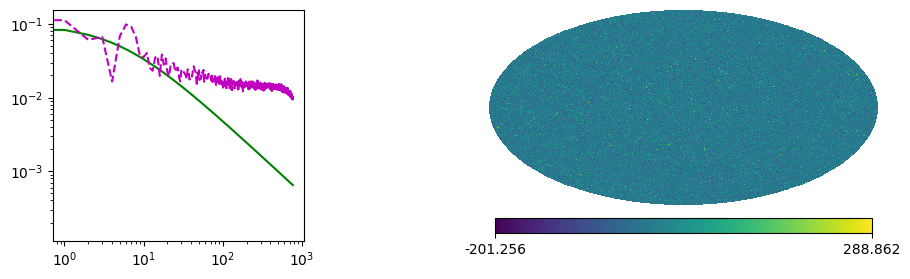

In [4]:
import matplotlib.gridspec as gs

plt.figure(figsize=(13,3))
grid = gs.GridSpec(1,2 , width_ratios=[1,3], wspace=0.005)
ax1 = plt.subplot(grid[0])
plt.loglog(ells, some_standard_cls, 'g-', label='some cls')
plt.loglog(ells, delta_cls, 'm--', label='some non-gaussian cls')
ax1 = plt.subplot(grid[1])
hp.mollview(delta, hold=True, title='')

## FSB signal

In [5]:
# defining some parameters

# filters
nbands = 5
fls = get_filters(nbands, nside)
# ells per bin
lpb = 17
# a visibility mask
test_lon, test_lat = hp.pix2ang(nside, np.arange(12*nside**2), lonlat=True)
mask = (test_lon >= 108) & (test_lon <= 265) & (test_lat >= -5) & (test_lat <= 70)


In [6]:
# initiating FSB class, which will contain all quantities needed to compute the FSB and its covariance
fsb_test = FSB(delta, mask1=mask, filters=fls, ells_per_bin=lpb)

(5, 45)


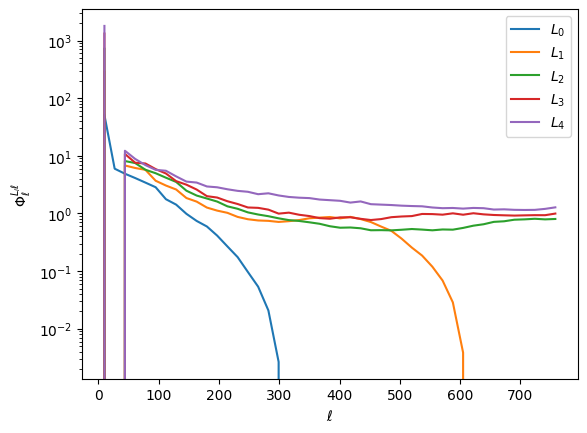

In [7]:
# let's plot the fsb
print(fsb_test.fsb_binned.shape) # 5 filters, 45 datapoints (bins)

for i, f in enumerate(fsb_test.fsb_binned):
    plt.semilogy(fsb_test.bb.get_effective_ells(), f, label=r'$L_{0}$'.format(i))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Phi_\ell^{L_i \ell}$')
plt.legend()

## FSB covariance

In [8]:
# we will plot the correlation function later

def cor(cov):
    return cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov)))  

In [20]:
# simulation-based

# for this we need to generate several realisations of our original non-gaussian map:
nsims = 1000
mapsims = np.zeros((nsims, npix))
# then we compute the FSB for each simulated map
fsbsims = np.zeros((nsims, nbands+1, fsb_test.b))
for s in range(nsims):
    if s%50==0:
        print(s)
    mapsims[s] = generate_map(some_standard_cls)
    fsb_s = FSB(mapsims[s], mask1=mask, filters=fls, ells_per_bin=lpb)
    fsbsims[s, :nbands] = fsb_s.fsb_binned
    fsbsims[s, -1:] = fsb_s.cls_binned

0


/tmp/ipykernel_3352948/1907776108.py:15: RuntimeWarning: divide by zero encountered in divide
  f = -1/(ells*(ells+1))


50
100
150
200
250
300


In [14]:
# compute the covariance

# reduce dimension
fsbsims_flat = np.array([l.flatten() for l in fsbsims])
# compute covariance from simulations
simcov = np.cov(fsbsims_flat.T)
print(simcov.shape, fsbsims_flat.shape)

(270, 270) (100, 270)


In [9]:
# analytical covariance

anacov = fsb_test.get_full_cov() # as simple as that

0
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
1
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
2
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
3
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
4
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27


[ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269]
[ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269]


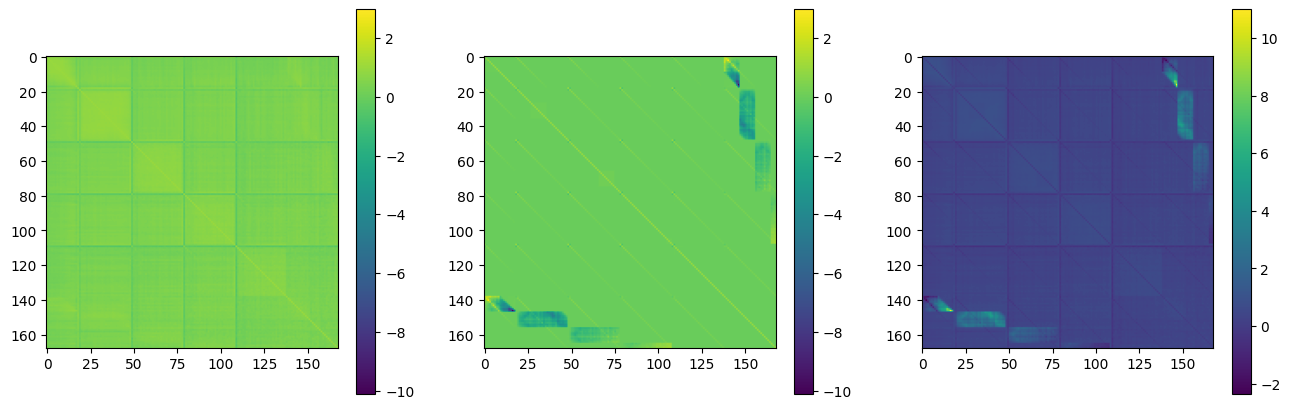

In [18]:
def fixflatm(m):

    until = 30
    nbins = 45
    # og matrix is 270 by 270
    ind_a_degager = np.array([np.arange((i)*nbins+until, (i+1)*nbins) for i in range(nbands+1)]).flatten()
    ind_a_degager = np.concatenate((np.arange(18, until), ind_a_degager))
    print(ind_a_degager)
        
    newm = np.delete(m, ind_a_degager, axis=0)
    newm = np.delete(newm, ind_a_degager, axis=1)

    return newm



plt.figure(figsize=(16,5))

simcor = fixflatm(cor(simcov))
anacor = fixflatm(cor(anacov))
mini = min(np.min(simcor), np.min(anacor))
maxi = max(np.max(simcor), np.max(anacor))

plt.subplot(131)
plt.imshow(simcor, vmin=mini, vmax=maxi)
plt.colorbar()
plt.subplot(132)
plt.imshow(anacor, vmin=mini, vmax=maxi)
plt.colorbar()
plt.subplot(133)
plt.imshow(simcor-anacor)
plt.colorbar() 